In [1]:
import tushare as ts
import pandas as pd
import statsmodels.tsa.stattools as stat
import numpy as np
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [2]:
pro = ts.pro_api()
pro = ts.pro_api('f7ee2dda50509f466b74a0eb3cbbe9a60b6c6cf16e3005949cf70672')
data = pro.daily(ts_code='600519.SH')

In [3]:
data = data.sort_values('trade_date')
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.set_index('trade_date',inplace=True)
data

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2001-08-27,600519.SH,34.51,37.78,32.85,35.55,31.39,4.16,13.2500,406318.00,1410347.179
2001-08-28,600519.SH,34.99,37.00,34.61,36.86,35.55,1.31,3.6900,129647.79,463463.143
2001-08-29,600519.SH,36.98,37.00,36.10,36.38,36.86,-0.48,-1.3000,53252.75,194689.620
2001-08-30,600519.SH,36.28,37.51,36.00,37.10,36.38,0.72,1.9800,48013.06,177558.558
2001-08-31,600519.SH,37.15,37.62,36.80,37.01,37.10,-0.09,-0.2400,23231.48,86231.237
...,...,...,...,...,...,...,...,...,...,...
2021-07-02,600519.SH,2075.00,2075.00,2011.50,2013.00,2105.00,-92.00,-4.3705,46275.31,9388640.194
2021-07-05,600519.SH,2000.00,2019.88,1985.00,1994.00,2013.00,-19.00,-0.9439,34420.95,6872797.768
2021-07-06,600519.SH,1995.00,2014.00,1960.01,2012.90,1994.00,18.90,0.9478,35282.51,7015883.091


In [4]:
seq_len = 21
dim_in = 4
dim_out = 4
pred_len = 30

In [5]:
v_mean = data.iloc[:, 1:5].apply(lambda x: np.mean(x))
v_mean

open     341.711477
high     346.599853
low      337.490706
close    342.267322
dtype: float64

In [6]:
v_std = data.iloc[:, 1:5].apply(lambda x: np.std(x))
v_std

open     466.948529
high     473.479057
low      461.087050
close    467.587526
dtype: float64

In [7]:
t0 = data.iloc[:, 1:5].apply(lambda x: (x - np.mean(x)) / np.std(x)).values
t0

array([[-0.65789152, -0.65223551, -0.66070107, -0.65595702],
       [-0.65686357, -0.65388289, -0.656884  , -0.65315541],
       [-0.65260186, -0.65388289, -0.65365251, -0.65418196],
       ...,
       [ 3.54062262,  3.52159218,  3.51890016,  3.57287692],
       [ 3.57274607,  3.55301913,  3.60348288,  3.55384305],
       [ 3.55154459,  3.50047192,  3.53622877,  3.51320894]])

In [8]:
X_train = np.zeros((t0.shape[0] - seq_len - pred_len, seq_len, dim_in))
X_train

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [9]:
Y_train = np.zeros((t0.shape[0] - seq_len - pred_len, dim_out), )
Y_train

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
X_test = np.zeros((pred_len, seq_len, dim_in))
X_test

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [11]:
Y_test = np.zeros((pred_len, dim_out), )
Y_test

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [12]:
for i in range(seq_len, t0.shape[0] - pred_len):
    Y_train[i - seq_len] = t0[i]
    X_train[i - seq_len] = t0[(i - seq_len):i]

In [13]:
for i in range(t0.shape[0] - pred_len, t0.shape[0]):
    Y_test[i - t0.shape[0] + pred_len] = t0[i]
    X_test[i - t0.shape[0] + pred_len] = t0[(i - seq_len):i]

In [14]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, dim_in), activation='relu', recurrent_dropout=0.01))
model.add(Dense(dim_out, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
history = model.fit(X_train, Y_train, epochs=200, batch_size=10, validation_split=0)

2021-07-08 23:42:15.192024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-08 23:42:15.701481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
470/470 [==============================] - 33s 16ms/step - loss: 0.1142
Epoch 2/200
470/470 [==============================] - 7s 16ms/step - loss: 0.0034
Epoch 3/200
470/470 [==============================] - 7s 16ms/step - loss: 0.0020
Epoch 4/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0017
Epoch 5/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0014
Epoch 6/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0014
Epoch 7/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0012
Epoch 8/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0012
Epoch 9/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0011
Epoch 10/200
470/470 [==============================] - 7s 15ms/step - loss: 9.8557e-04
Epoch 11/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0010
Epoch 12/200
470/470 [==============================] - 7s 15ms/step - loss: 0.0

In [16]:
pred_df = model.predict(X_test) * v_std.values + v_mean.values
pred_df

array([[2212.59943037, 2263.78667033, 2185.62913362, 2228.73297593],
       [2250.62659214, 2299.65490705, 2221.57042984, 2265.92634367],
       [2212.41974503, 2263.88646173, 2182.4450713 , 2227.78805828],
       [2194.59816594, 2242.99912738, 2163.69929464, 2208.41535132],
       [2238.64534313, 2289.70421393, 2206.53924598, 2252.49370832],
       [2215.39268011, 2267.79074399, 2183.41532866, 2230.16038574],
       [2222.66091857, 2271.68170567, 2189.74783542, 2236.07403623],
       [2254.15305603, 2306.09438768, 2219.19326633, 2266.89578726],
       [2258.17382159, 2311.12866084, 2221.66123344, 2270.53543702],
       [2179.56861197, 2233.92499564, 2145.84572382, 2194.98895894],
       [2191.42060778, 2238.85631658, 2158.55141209, 2204.25842715],
       [2238.25880813, 2289.9074091 , 2204.36655547, 2251.29706533],
       [2170.71192842, 2222.59054343, 2139.3605219 , 2186.15482619],
       [2183.85701294, 2231.08195659, 2153.49938999, 2198.41690523],
       [2155.70007579, 2206.334478

In [17]:
pred_df.shape

(30, 4)

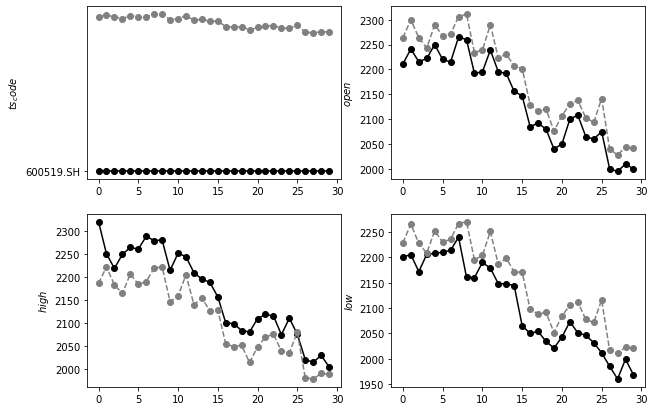

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(30), data.iloc[-30:data.shape[0], i].values, 'o-', c='black')
    plt.plot(range(30), pred_df[:, i], 'o--', c='gray')
#     plt.ylim(1000, 1200)
    plt.ylabel("$" + data.columns[i] + "$")
plt.show()


In [22]:
v = 100 * (1 - np.sum(np.abs(pred_df - data.iloc[-30:data.shape[0], 1:5]).values) / np.sum(
    data.iloc[-30:data.shape[0], 1: 5].values))
print("Evaluation on test data: accuracy = %0.2f%% \n" % v)

Evaluation on test data: accuracy = 99.02% 

